<h1>QCut demo on Helmi quantum computer</h1>

In this notebook we present a simple demo of how to perform wire-cuts using the QCut package on a real quantum computer. Here we use the 5-qubit Helmi quantum computer that is a part of the Finnish Quantum Computing Infrastructure (FiQCI) HPC+QC framwork. Helmi can be accessed through the Lumi supercomputer. For more information go to <a href="https://docs.csc.fi/computing/quantum-computing/helmi/running-on-helmi/">Helmi docs</a>

<h2>Before proceeding</h2>

Make sure to have installed all of the required packages. For this notebook you need to do:

```python
pip install QCut
pip install qiskit-iqm
pip install pylatexenc
```

Everything else is installed as a dependency.

<h2>First we import needed packages</h2>

We import QCut, numpy and some qiskit components. Additionally we set some print options for numpy.

In [1]:
import QCut as ck
from QCut import cut_wire
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator

import numpy as np
np.set_printoptions(formatter={"float": lambda x: f"{x:0.6f}"})

<h2>Define initial circuit</h2>

Define the initial uncut circuit that we want to run.

c:\Users\nivalajo\AppData\Local\miniconda3\envs\QCut\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


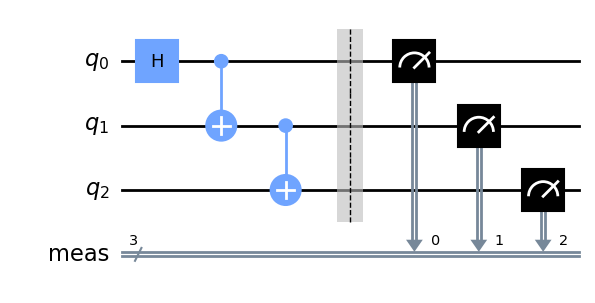

In [2]:
circuit  =  QuantumCircuit(3)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
   
circuit.measure_all()

circuit.draw("mpl")

<h2>Insert cuts in to the circuit</h2>

Define a new circuit that represents the cut circuit. Here we insert the cut as a two qubit cut_wire gate and add an extra qubit for the wire-cut. Notice how all the operations after the cut have been move onto a new qubit.

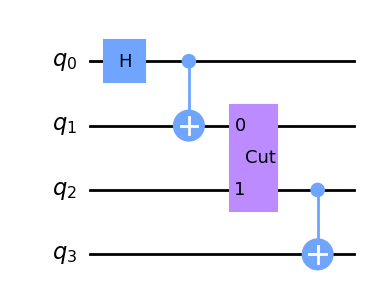

In [3]:
cut_circuit = QuantumCircuit(4)
cut_circuit.h(0)
cut_circuit.cx(0,1)
cut_circuit.append(cut_wire, [1,2])
cut_circuit.cx(2,3)

cut_circuit.draw("mpl")

<h2>Split to separate subcircuits</h2>

Extract the cut locations from cut_circuit and split it into separate subcircuits

In [4]:
cut_locations, subcircuits = ck.get_locations_and_subcircuits(cut_circuit)

For visualization print the subcircuits

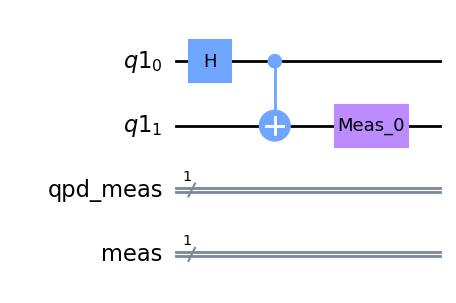

In [5]:
subcircuits[0].draw("mpl")

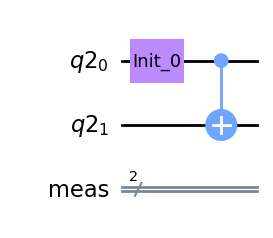

In [6]:
subcircuits[1].draw("mpl")

<h2>Get experiment circuits</h2>

Generate all of the experiment circuit by inserting operations from the identity channel Quasi-probability distribution (QPD). Additionally calculate coefficients for subcircuit groups and generate some metadata for processing the results. First let's go over what is a QPD and how that is used for wire-cutting.

### Quasi-probability distribution

A quasi-probability distribution is, as the name suggests, a probability distribution with some relaxed conditions. Most notably the weights of the distribution terms can be negative. They do however retain the property to yield expectation values. In circuit knitting quasi-probability distributions are used to decompose a quantum channel into a *set* of quantum channels. The expectation value of the original channel can be reconstructed from the combined results of the decomposed channel. For our purposes, we will consider quasi-probability distributions as sets of quantum channels with some coefficients. 

The weights for the operations are given by

$$p_1=\frac{|c_i|}{\gamma} \text{, where}$$
$$\gamma = \sum_i{|c_i|},$$
where $c_i$ are some coefficients <a href="#references">[2]</a>.


### Quasi-Probability Distribution Simulation

Wire-cutting (and essentially all other circuit knitting) relies on quasi-probability distribution (QPD) simulation. In the context of wire-cutting this is essentially a list of quantum channels with associated coefficients of +-½ that can be used to approximate the identity channel. This means that by probabilistically applying these operations (sampling the QPD) enough times we can approximate an identity gate (an empty wire) to an arbitrary degree. The number of samples needed for an approximation of error $\epsilon$ is given by
$$N = \gamma^{2n} \frac{1}{\epsilon^2} \text{,}$$

where n is the number of cuts made. The QPD for an identity channel is
$$Id(\bullet) = \sum_{i = 1}^{8} c_i Tr[O_i(\bullet)] \rho_i \text{,}$$

and the operations $O_i$ and $\rho_i$ can be given as <a href="#references">[2]</a>.

<a id="qdplist"></a>

| $ O_i $     | $ \rho_i $                    | $ c_i $        |
|-------------|-------------------------------|----------------|
| $ O_1 = I $ | $ \rho_1 = \ket 0\bra 0 $     | $ c_1 = +1/2 $ |
| $ O_2 = I $ | $ \rho_2 = \ket 1\bra 1 $     | $ c_2 = +1/2 $ |
| $ O_3 = X $ | $ \rho_3 = \ket +\bra + $     | $ c_3 = +1/2 $ |
| $ O_4 = X $ | $ \rho_4 = \ket -\bra - $     | $ c_4 = -1/2 $ |
| $ O_5 = Y $ | $ \rho_5 = \ket{+i}\bra{+i} $ | $ c_5 = +1/2 $ |
| $ O_6 = Y $ | $ \rho_6 = \ket{-i}\bra{-i} $ | $ c_6 = -1/2 $ |
| $ O_7 = Z $ | $ \rho_7 = \ket 0\bra 0 $     | $ c_7 = +1/2 $ |
| $ O_8 = Z $ | $ \rho_8 = \ket 1\bra 1 $     | $ c_8 = -1/2 $ |



*An important point about notation*: $\rho_i$ are a density matrices corresponding to a state to be prepared and $O_i$ are basis measurements, sets of operations transforming the state from one basis to another and measuring it. The identity basis here means that measurement will always yield the zero state $\ket{0}$.

The QPD contains two types of operations. Basis measurements and state initializations. The basis measurements are inserted at the cut location and the state initializations to the beginning of the new qubit wire.

Now to be able to estimate the original circuit's expectation values we need to insert operations from the <a href="#qdplist">QPD</a>, creating a total of 8 subcircuit pairs (one for each row in the <a href="#qdplist">QPD</a> ). In a more general setting, the total number of subcircuit groups of size *k* is given by $8^n$, where *n* is the number of cuts made and *k* is the number of parts the circuit is cut to. In addition to the number of circuits, also the number of samples needed scales exponentially with the number of cuts. Thus, the time complexity scales exponentially with the number of cuts. The sampling overhead can be represented in the big-O notation as O(${\gamma^{2n}}$) <a href="#references">[2]</a>, where $\gamma$ is the sum of the absolute values of the coefficients of the QPD (4 for wire-cutting). If more than one cut is made the operations for each circuit are given by the cartesian product of the QPD with itself repeated for each cut. After running all of the subcircuits on a simulator or a quantum computer we can use classical post-processing to reconstruct the expectation values.

In [7]:
experiment_circuits, coefficients, id_meas = ck.get_experiment_circuits(subcircuits, cut_locations)


One can check that the number of circuits is indeed correct by printing the lenghts of experiment_circuits and its first element

In [8]:
print(f"Number of circuit groups: {len(experiment_circuits)}")
print(f"Size of a circuit group: {len(experiment_circuits[0])}")
print(f"Total subcircuits: {len(experiment_circuits)*len(experiment_circuits[0])}")

Number of circuit groups: 8
Size of a circuit group: 2
Total subcircuits: 16


<h2>Get the backend</h2>

If running through FiQCI set backend_name to "helmi" else set it to "fake" or "sim" to use a noisy or ideal simulator, respectively.

In [9]:
import os
from iqm.qiskit_iqm import IQMProvider, IQMFakeAdonis
from qiskit_aer import AerSimulator

backend_name = "sim" #"helmi", "fake", "sim"

if backend_name == "fake":
    backend = IQMFakeAdonis()
elif backend_name == "helmi":
    HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')  # This is set when loading the module

    provider = IQMProvider(HELMI_CORTEX_URL)
    backend = provider.get_backend()
elif backend_name == "sim":
    backend = AerSimulator()
else:
    raise Exception("Invalid backend name")

<h2>Transpile experiment circuits</h2>

Transpile experiment circuits to operations that the backend can realise.

In [10]:
experiment_circuits = ck.transpile_experiments(experiment_circuits, backend)

<h2>Run experiments</h2>

Run the transpiled experiment circuits on the backend.

In [11]:
results = ck.run_experiments(experiment_circuits, cut_locations, id_meas, backend=backend, mitigate=False)

<h2>Estimate expectation values</h2>

Set obsevables that we wish to calculate expectation values for and calculate the estimated epxectation values.

First, it is important to notice that in our circuits we now have two kinds of measurements. The normal end-of-circuit observable measurements on the qubits we want to consider for the expectation values, and the basis measurements on the extra qubits added by wire-cuts. While the end-of-circuit measurement results are used for expectation values, the basis measurement results are used for determining coefficients for the results of each subcircuit group. 

Now, once all the subcircuit groups have been run and results collected, we can apply classical post-processing on the results. First, we choose a random circuit group result according to the QPD weights. Since for wire-cuts, the weights are all equal we just pick a random result. Then we map the measured qubit state to its eigenvalue by applying $f:\{0,1\}^N \rightarrow [-1,1]^N$ [1] <a href="#references">[2]</a>. This means that for example, if we have 4 qubits and the states of indidividual qubits are [0, 1, 1, 0], we transform it to [-1, 1, 1, -1]. Next, we want to apply $sgn(c_i)\cdot sf(\bold{y})$ <a href="#references">[2]</a>, where $\bold{y}$ are the results of the end-of-circuit measurements, *s* the coefficient given by multiplying all the basis measurement results, and $sgn(c_i)$ is the sign of the product of coefficients of this circuit group from the identity channel <a href="#qdplist">QPD</a>. Once this has been repeated for a large enough number of times (enough samples have been collected) we can calculate the expectation value by taking the mean of the samples and multiplying it by $(-1)^{n+1}\cdot 4^{2n}$ <a href="#references">[2] [1]</a>, where *n* is the number of cuts. 

Note that the above description will give the Pauli Z-observable expectation value for each qubit. If one doesn't need the expectation value for each qubit those results can simply be ignored in the calculation. For multi-qubit expectation values after aplying *f* the eigenvalue of a multi-qubit state is given by the product of the eigenvalues for each qubit. After which, and additional multiplication by $(-1)^{m+1}$, where *m* is the number of qubits in the expectation value, is needed.

We can calculate the overhead and the number of needed samples for and error of $\epsilon$=0.01. Remember that $\gamma$ for wire-cuts is 4

In [12]:
print(f"Overhead: {np.power(4, 1*2)}")
print(f"Number of samples N: {np.power(4, 1*2)/np.power(0.01,2)}")

Overhead: 16
Number of samples N: 160000.0


A naive way of doing the sampling would be to pick a random subcircuit group and take a single shot from each circuit in the group, repeat this N times and use these results to estimate the expectation value. A smarter way is to take enoug shots for each subcircuit so that the underlying probability distrubution becomes clear. Then we can artificially inflate the number of samples by normalizing the counts from each subcircuit and multiplying them by a large number. Now we can iterate through all of the subcircuit group results, apply the post processing on each possible state and use that to calculate the estimated expectation value. This significantly reduces the number of loop iteration required to calculate the expectatio values.

In [13]:
observables = [0,1,2, [0,2]]
expectation_values = ck.estimate_expectation_values(results, coefficients, cut_locations, observables)

<h2>Run the circuit without wire-cutting</h2>

Run the initial circuit as a whole without wire cutting on the backend and claculate expectation values for observables.

In [14]:
from qiskit import transpile

circuit = transpile(circuit, backend, optimization_level=3)
helmi_res = ck.run_and_expectation_value(circuit, backend, observables, 2**12, mitigate = False)

<h2>Get ideal expectation values</h2>

Get the ideal expectation values with qiskit Estimator.

In [15]:
paulilist_observables = ck.get_pauli_list(observables, circuit.num_qubits)

estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(paulilist_observables),
                  list(paulilist_observables)).result().values
)

<h2>Print results</h2>

Print results and compare.


Note that if running on a fake backend the results don't match the ones obtained with the actual quantum computer. This die to the fake backend not exactly matching the noise of the real hardware. This causes QCut to perform worse than just running the circuit as a whole. Realistically on erronous hardware circuits with less gates and qubits will always yeild better results than one with more gates and qubits.

You can however also see that setting the backend to "sim" QCut is able to obtain near ideal results.

In [16]:
print(f"QCut circuit knitting expectation values:{np.array(expectation_values)}")
print(f"Expectation values without circuit knitting :{np.array(helmi_res[1])}")
print(f"Exact expectation values with ideal simulator :{np.array(exact_expvals)}")

QCut circuit knitting expectation values:[0.010078 0.010078 -0.007080 1.011427]
Expectation values without circuit knitting :[0.005371 0.005371 0.005371 1.000000]
Exact expectation values with ideal simulator :[0.000000 0.000000 0.000000 1.000000]


<h2>Shorthand for QCut</h2>

With QCut the whole wire-cutting procedure can also be executed with just a single function call.

In [17]:
shorthand_res = ck.run(cut_circuit, observables, backend=backend, mitigate=False)

print(f"QCut circuit knitting expectation values:{np.array(shorthand_res)}")


QCut circuit knitting expectation values:[0.026043 0.026043 -0.035156 1.003686]


## References <a id="references"></a>

1. T. Peng, A. W. Harrow, M. Ozols, and X. Wu, “Simulating Large Quantum Circuits on a Small Quantum Computer,” Phys. Rev. Lett., vol. 125, no. 15, p. 150504, Oct. 2020, doi: 10.1103/PhysRevLett.125.150504. Available: https://link.aps.org/doi/10.1103/PhysRevLett.125.150504. [Accessed: Aug. 14, 2024]

2. H. Harada, K. Wada, and N. Yamamoto, “Doubly optimal parallel wire cutting without ancilla qubits.” arXiv, Nov. 07, 2023. doi: 10.48550/arXiv.2303.07340. Available: http://arxiv.org/abs/2303.07340. [Accessed: Aug. 14, 2024]
